In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import random
import time
import copy
import glob 
from PIL import Image
import cv2 
from PIL import Image

import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(os.listdir("../input"))

['train', 'test', 'train.csv', 'sample_submission.csv']


In [48]:
use_gpu = torch.cuda.device_count() > 0
print("{} GPU's available:".format(torch.cuda.device_count()) )

1 GPU's available:


In [49]:
'''
if use_gpu:
     !watch -n 1 nvidia-smi
'''

'\nif use_gpu:\n     !watch -n 1 nvidia-smi\n'

In [50]:
base_dir = '../input'
train_image_dir = os.path.join(base_dir, 'train')
test_image_dir = os.path.join(base_dir, 'test')

In [51]:
df = pd.read_csv(base_dir + '/train.csv')

In [52]:
df['green_path'] = df['Id'].map(lambda x: os.path.join(train_image_dir, '{}_green.png'.format(x)))
df['target_list'] = df['Target'].map(lambda x: [int(a) for a in x.split(' ')])

In [53]:
df.head()

,Id,Target,green_path,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,../input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6...,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,../input/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6...,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,../input/train/000a9596-bbc4-11e8-b2bc-ac1f6b6...,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,../input/train/000c99ba-bba4-11e8-b2b9-ac1f6b6...,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,../input/train/001838f8-bbca-11e8-b2bc-ac1f6b6...,[18]


In [54]:
X = df['green_path'].values
y = df['target_list'].values

In [55]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = test_size) 

In [56]:
class CellsDataset(Dataset):

    def __init__(self, X, y=None, transforms=None, nb_organelle=28):
        
        self.nb_organelle = nb_organelle
        self.transform = transforms 
        self.X = X
        self.y = y
            
    def open_rgby(self, path2data): #a function that reads RGBY image
        
        Id = path2data.split('/')[-1].split('_')[0]
        basedir = '/'.join(path2data.split('/')[:-1])
        
        images = np.zeros(shape=(512,512,3)) #4
        colors = ['red','green','blue'] #,'yellow'
        for i, c in enumerate(colors):
            images[:,:,i] = np.asarray(Image.open(basedir + '/' + Id + '_' + c + ".png"))
        return images.astype(np.uint8)
    
    def __getitem__(self, index):
        
        path2img = self.X[index]
        image = self.open_rgby(path2img)

        if self.y is None:
            labels =np.zeros(self.nb_organelle,dtype=np.int)
        else:
            label = np.eye(self.nb_organelle,dtype=np.float)[self.y[index]].sum(axis=0)
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

In [57]:
class AdjustGamma(object):
    def __call__(self, img):
        return transforms.functional.adjust_gamma(img, 0.8, gain=1)

In [58]:
class AdjustContrast(object):
    def __call__(self, img):
        return transforms.functional.adjust_contrast(img, 2)

In [59]:
class AdjustBrightness(object):
    def __call__(self, img):
        return transforms.functional.adjust_brightness(img, 2)

In [60]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [61]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(), # because the input dtype is numpy.ndarray
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AdjustGamma(),
        AdjustContrast(),
        ##AdjustBrightness(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.ToPILImage(), # because the input dtype is numpy.ndarray
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        AdjustGamma(),
        AdjustContrast(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

In [62]:
dsets = {
    'train': CellsDataset(X, y, transforms=data_transforms['train']),
    'valid': CellsDataset(X, y, transforms=data_transforms['valid']),
#    'test':  CellsDataset('../input/test', None,  transforms=data_transforms['valid']),
}

In [63]:
batch_size = 32
random_seed = 3
valid_size = 0.2
shuffle = True

In [64]:
num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

In [65]:
def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
    dset_loaders = {} 
    for key in dsets.keys():
        if sampler[key] != None:
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
        else:          
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)

    return dset_loaders

In [66]:
dset_loaders = create_dataLoader(dsets, batch_size, sampler, pin_memory=False)

In [67]:
dset_loaders.keys()

dict_keys(['train', 'valid'])

In [68]:
def plot_organelles(dset_loaders, is_train = True, preds_test = [], preds_train = []):
    
    X, y = next(iter(dset_loaders))
    X, y = X.numpy(), y.numpy()
    
    plt.figure(figsize=(20,10))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)
        
        rand_img = random.randrange(0, X.shape[0])
        img = denormalize(X[rand_img,:,:,:])
        plt.imshow(img)
        plt.axis('off')

In [69]:
image, label = next(iter(dset_loaders['train']))
print(image.size(), label.size())

torch.Size([32, 3, 512, 512]) torch.Size([32, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


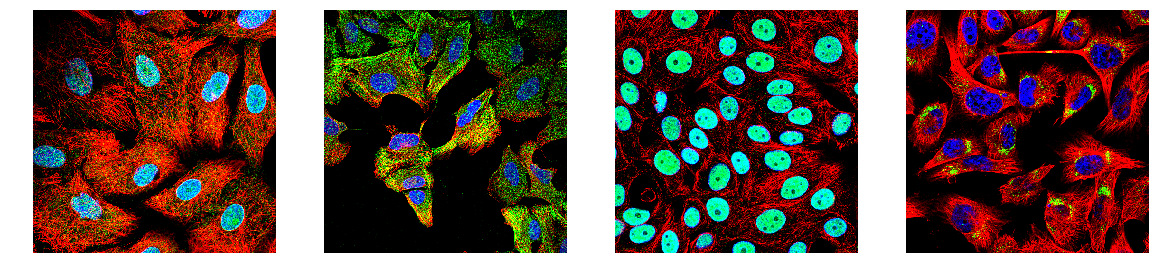

In [70]:
plot_organelles(dset_loaders['train'])

In [121]:
class Densenet161(nn.Module):
    def __init__(self, num_classes = 28):
        super(Densenet161,self).__init__()
        original_model = models.densenet161(pretrained=True)
        for param in original_model.parameters():
            param.requires_grad = False
            
        self.features = nn.Sequential(*list(original_model.children())[:-1])     
        self.f1 = nn.Linear(8832, 2208)
        self.f2 = nn.Linear(2208, num_classes)

    def forward(self, x):
        f = self.features(x)
        f = F.relu(f, inplace=True)
        f = F.avg_pool2d(f, kernel_size=7).view(f.size(0), -1)
        y = self.f1(f)
        y = self.f2(y)
        return f,y

In [122]:
model = Densenet161()

In [123]:
if use_gpu:
    print("Using all GPU's ")
    #model = torch.nn.DataParallel(model) #device_ids=[1,3]
    model.cuda()
else:
    print("Using CPU's")

Using all GPU's 


In [124]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, ( inputs, labels) in enumerate(loader):     
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.item()
            
    return (total_loss / i)

In [ ]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            print(' {}  {}'.format(predict[0].size(), predict[1].size()))
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.item())
        loss_test.append( evaluate_model(test_loader, model,loss_fn, use_gpu) )
        
        print('\nEpoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        
        #Early stopping
        if(best_test_acc > loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    return loss_train, loss_test, model

In [ ]:
loss_fn = torch.nn.MultiLabelSoftMarginLoss()
optimizer =  optim.Adam(model.parameters())
num_epochs = 100
patience = 5

In [ ]:
params = {'model' : model, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
         'optimizer': optimizer, 
         'patience': patience 
         }

In [ ]:
loss_train, loss_test, model = train(**params)

In [ ]:
def predict(dset_loaders, model,use_gpu=False):
    
    predictions = []
    labels_lst = []

    ii_n = len(dset_loaders)
    start_time = time.time()

    for i, (inputs, labels) in enumerate(dset_loaders):
                   
        if use_gpu:
          inputs = inputs.cuda()
          labels = labels.cuda()

        inputs = Variable(inputs)
        labels = Variable(labels)

        predictions.append(model(inputs).data)
        labels_lst.append(labels)
        
        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    print('Execution time {0:.2f} s'.format(round(time.time()- start_time), 2))
    if len(predictions) > 0:
        return {'pred': torch.cat(predictions, 0), 'true': torch.cat(labels_lst, 0) }

In [ ]:
print(classification_report(pred_dict['test'], true_dict['test']))